# Training and testing of the individual models
In this notebook, we trained the best ANN architectures per dataset, as defined by the parameter_optimization_best_models.txt file in the logs/ directory. We trained them on the training sets located in the data/cleaned_data/spacers/ directory, and tested them on the testing set located in the same directory.
The models that were trained, were also saved in the state_dicts/ directory as PyTorch state dictionaries.

## 1. Preamble
### Load packages, define basic variables and load small custom functions

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score

In [ ]:
dfs = [B_F, B_W, B_WT, F_B, F_W, F_WT, W_B, W_F, W_WT]
df_names = ['B_F', 'B_W', 'B_WT', 'F_B', 'F_W', 'F_WT', 'W_B', 'W_F', 'W_WT']
device = torch.device('cuda')

In [ ]:
def one_hot_sequence(seq):
    d = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    length = len(seq)
    m = np.zeros((4, length), dtype='float32')
    
    for i, b in enumerate(seq):
        m[d[b]][i] = 1   
    return m

def outputSize(in_size, kernel_size, stride, padding):
    return int((in_size - kernel_size + 2*(padding)) / stride) + 1

def num_flat_features(x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

### Load custom PyTorch Dataset classes 
There is one class for Convolutional Neural Networks and one for fully-connected Artificial Neural Networks

In [4]:
class Dataset_ConvNeuralNet(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        data = torch.from_numpy(one_hot_sequence(self.X.iloc[idx]))
               
        # We add one dimension for the channels, because the channels have to be in the second position
        # The first dimension are the batches
        data = data[None, :, :].to(device, dtype=torch.float32)
        target = torch.from_numpy(np.array(self.y.iloc[idx])).to(device, dtype=torch.long)        
        return data, target

In [5]:
class Dataset_SimpleNeuralNet(Dataset):
    def __init__(self, X, y):
        
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        data = torch.from_numpy(one_hot_sequence(self.X.iloc[idx]).flatten()) # Flatten tensor
        data = data.to(device, dtype=torch.float32) # Move to gpu
        
        target = np.array(self.y.iloc[idx])
        target = torch.from_numpy(target).to(device, dtype=torch.long) # convert to tensor and move to gpu

        return data, target

### Load train function

In [6]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          log,
          max_epochs_stop=3,
          n_epochs=3,
          plot_metrics=True):
    '''Train a PyTorch Model

    Params
    --------
        model (PyTorch model): neural network to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        log (Logger object): class to log all changes in metrics
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats
        plot_metrics (bool): boolean to plot metrics or not

    Returns
    --------
        model (PyTorch model): trained neural network with best weights
        history (DataFrame): history of train and validation loss
        
    based on:
    https://github.com/WillKoehrsen/pytorch_challenge/blob/master/Transfer%20Learning%20in%20PyTorch.ipynb
    '''

    epochs_no_improve = 0
    valid_loss_min = np.Inf
    model.epochs = 0
    early_stopping = False
    
    # Main loop
    for _ in range(n_epochs):
        
        # Initialize metrics with dummy values
        log.initialize()

        # Set model to training
        model.train()

        # Training loop
        for mini_batch_number, (data, target) in enumerate(train_loader):

            # Clear gradients
            optimizer.zero_grad()
            
            # Predicted outputs
            output = model(data)
            
            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()
            
            # Log targets, outputs and loss
            log.log_metrics(target, output, loss, mode='train')
            
            # Print training completion percentage
            log.print_training_process(mini_batch_number, len(train_loader))
        
        # After training ends, start validation
        model.epochs += 1

        # Don't need to keep track of gradients
        with torch.no_grad():
            

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for data, target in valid_loader:
                                
                # Predicted outputs
                output = model(data)

                # Validation loss
                loss = criterion(output, target)

                # Log targets, outputs and loss
                log.log_metrics(target, output, loss, mode='valid')
                
            # Log metrics that can only be calculated at the end of an epoch (auc, p-r, ...)
            log.log_end_of_epoch_metrics(len(train_loader.dataset), mode='train')
            log.log_end_of_epoch_metrics(len(valid_loader.dataset), mode='valid')
            
            # Save the model if validation loss decreases
            if log.metrics_dict['loss']['valid'][-1] < valid_loss_min: # valid_loss_min == np.Inf for first Epoch
                      
                # Save model
                torch.save(model.state_dict(), save_file_name)

                # Track improvement
                epochs_no_improve = 0
                best_epoch = log.epoch
                valid_loss_min = log.metrics_dict['loss']['valid'][-1]
                
                # Print metrics
                log.print_metrics([], save_model=True)
                      
            # Otherwise increment count of epochs with no improvement
            else:
                epochs_no_improve += 1
                
                # Print metrics
                log.print_metrics([], save_model=False)
                
                # Trigger early stopping
                if epochs_no_improve >= max_epochs_stop:
                    
                    early_stopping=True

                    # Load the best state dict
                    model.load_state_dict(torch.load(save_file_name))
                    model.epochs = best_epoch
                    
                    break
                    
    # Attach the optimizer
    model.optimizer = optimizer
    
    log.print_final_metrics(best_epoch, early_stopping)
    if plot_metrics:
        log.plot_metrics(best_epoch, save_file_name.split("/")[-1][:-3])

    return model, log.history

### Load custom Logger class, which is to be used with the train function

In [7]:
class Singlelabel_Logger:
    
    def __init__(self, print_every=1):
                
        # Initialize Logger object attributes
        self.print_every = print_every
        self.epoch = 0
        self._history = pd.DataFrame()

        # Initialize a dictionary
        self._metrics_dict = {'loss': {'train': [], 'valid': []},
                             'target': {'train': [], 'valid': []}, 
                             'output': {'train': [], 'valid': []},
                             'accuracy': {'train': [], 'valid': []},
                             'roc_auc': {'train': [], 'valid': []},
                             'tpr': {'train': [], 'valid': []},
                             'fpr': {'train': [], 'valid': []},
                             'pr_auc': {'train': [], 'valid': []},
                             'precision': {'train': [], 'valid': []},
                             'recall': {'train': [], 'valid': []}}
        
    @property
    def metrics_dict(self):
        return self._metrics_dict         
               
    @property
    def history(self):
        # Dataframe to track history
        for metric, values in self.metrics_dict.items():
                self._history[f'train_{metric}'] = pd.Series(values['train'], index=range(1, self.epoch+1))
                self._history[f'valid_{metric}'] = pd.Series(values['valid'], index=range(1, self.epoch+1))
        return self._history.round(4)
            
    def log_metrics(self, target, output, loss, mode='train'):
        
        assert mode in ['train', 'valid'], 'mode must be "train" or "valid"'
        
        # Multiply average loss by number of examples in a minibatch
        self.metrics_dict['loss'][mode][-1] += loss.item() * len(target)
        
        # Append target and output to lists
        self.metrics_dict['target'][mode][-1] = np.append(self.metrics_dict['target'][mode][-1], target.data.cpu().numpy())
        self.metrics_dict['output'][mode][-1] = np.vstack((self.metrics_dict['output'][mode][-1], output.data.cpu().numpy()))
        
    def log_end_of_epoch_metrics(self, dataset_size, mode='train'):
        
        assert mode in ['train', 'valid'], 'mode must be "train" or "valid"' 
        
        # Loss over one epoch is the average of the loss over the entire dataset
        self.metrics_dict['loss'][mode][-1] /= dataset_size 
        
        # Calculate Accuracy        
        pred = np.argmax(self.metrics_dict['output'][mode][-1], axis=1)       
        target = self.metrics_dict['target'][mode][-1]
        correct = (pred == target)
        self.metrics_dict['accuracy'][mode][-1] = sum(correct) / len(correct)

        # Calculate true positive rate and false positive rate
        fpr, tpr, _ = roc_curve(self.metrics_dict['target'][mode][-1], 
                                self.metrics_dict['output'][mode][-1][:, 1]) # select positive class

        # Add false positive rate and true positive rate to the metrics dictionary
        self.metrics_dict['fpr'][mode][-1] = fpr
        self.metrics_dict['tpr'][mode][-1] = tpr
        
        # Add ROC AUC to the metrics dictionary
        self.metrics_dict['roc_auc'][mode][-1] = auc(fpr, tpr)

        # Add precision and recall to the metrics dictionary
        precision, recall, _ = precision_recall_curve(self.metrics_dict['target'][mode][-1], 
                                                      self.metrics_dict['output'][mode][-1][:, 1])
        self.metrics_dict['precision'][mode][-1] = precision
        self.metrics_dict['recall'][mode][-1] = recall

        # Add precision recall auc to the metrics dictionary
        average_precision = average_precision_score(self.metrics_dict['target'][mode][-1], 
                                                    self.metrics_dict['output'][mode][-1][:, 1])
        self.metrics_dict['pr_auc'][mode][-1] = average_precision
            
    def print_training_process(self, mini_batch_number, total_minibatches, timer=False):
        print(f'Epoch: {self.epoch}\t{100 * (mini_batch_number + 1) / total_minibatches:6.2f}% complete.', end='\r')
    
    def print_metrics(self, metrics_to_print, save_model=False):
        output_str = [f'\n\t\tTraining Loss: {self.metrics_dict["loss"]["train"][-1]:.4f}\t\tValidation Loss: {self.metrics_dict["loss"]["valid"][-1]:.4f}']

        if 'accuracy' in metrics_to_print:
            output_str.append(f'\n\t\tTraining accuracy: {self.metrics_dict["accuracy"]["train"][-1]:.4f}\t\tValidation accuracy: {self.metrics_dict["accuracy"]["valid"][-1]:.4f}')
                      
        if 'roc_auc' in metrics_to_print:
            output_str.append(f'\n\t\tTraining roc_auc: {self.metrics_dict["roc_auc"]["train"][-1]:.4f}\t\tValidation AUC: {self.metrics_dict["roc_auc"]["valid"][-1]:.4f}')

        if 'pr_auc' in metrics_to_print:
            output_str.append(f'\n\t\tTraining pr_auc: {self.metrics_dict["pr_auc"]["train"][-1]:.4f}\t\tValidation P-R: {self.metrics_dict["pr_auc"]["valid"][-1]:.4f}')
        
        if save_model:
            output_str.append(f'\t\tSaving...')                    
        
        # Print every n epochs (e.g. 2, print only even epochs)
        if (self.epoch) % self.print_every == 0:
            print(''.join(output_str)+'\n')
                              
    def print_final_metrics(self, model_epochs, early_stopping=False):
        early_stopping_str = f'\nEarly Stopping! Total epochs: {self.epoch}. Best epoch: {model_epochs}' if early_stopping else f'\nTotal epochs: {self.epoch}'
        output_str = [f'{early_stopping_str} with loss: {self.history["valid_loss"][model_epochs]}']
        output_str.append(f'accuracy: {self.history["valid_accuracy"][model_epochs]}')
        output_str.append(f'roc_auc: {self.history["valid_roc_auc"][model_epochs]}')
        output_str.append(f'roc_pr: {self.history["valid_pr_auc"][model_epochs]}')
        print(', '.join(output_str))
                                                            
    def initialize(self):
                                 
        # Start the next epoch
        self.epoch += 1
                   
        # Initialize metrics to record a new epoch
        for mode in ['train', 'valid']:
            self.metrics_dict['loss'][mode].append(0)
            self.metrics_dict['target'][mode].append([])
            self.metrics_dict['output'][mode].append(np.empty((0, 2)))
            self.metrics_dict['accuracy'][mode].append([])
            self.metrics_dict['tpr'][mode].append([])
            self.metrics_dict['fpr'][mode].append([])
            self.metrics_dict['roc_auc'][mode].append([])
            self.metrics_dict['pr_auc'][mode].append([])
            self.metrics_dict['precision'][mode].append([])
            self.metrics_dict['recall'][mode].append([])

    def plot_metrics(self, best_epoch, model_name):
        fig = plt.figure(figsize=(16, 10))                 
        ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)
        ax2 = plt.subplot2grid((2, 3), (1, 0))
        ax3 = plt.subplot2grid((2, 3), (1, 1))
        ax4 = plt.subplot2grid((2, 3), (1, 2))

        # Plot Loss curves
        for c in ['train_loss', 'valid_loss']:
            ax1.plot(self.history[c], label=c)
        ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Average Negative Log Likelihood')
        ax1.set_title('Training and Validation Losses')
        ax1.axvline(best_epoch,linestyle='--', color='red', label='model epochs')
        ax1.legend()
        
        # Plot accuracy
        for c in ['train_accuracy', 'valid_accuracy']:
            ax2.plot(self.history[c], label=c)
        ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Validation Accuracy')
        ax2.set_title('Validation Accuracy per epoch')
        ax2.axvline(best_epoch,linestyle='--', color='red', label='model epochs')
        ax2.legend()

        # Plot roc auc
        # History starts counting from 1 so it is ok
        best_auc = self.history['valid_roc_auc'][best_epoch]
        best_pr = self.history[f'valid_pr_auc'][best_epoch]           
        # Best epoch -1 because python lists start counting from 0 and epochs are numbered counting from 1
        ax3.plot(self.metrics_dict['fpr']['valid'][best_epoch-1],
                 self.metrics_dict['tpr']['valid'][best_epoch-1],
                 label=f'area = {best_auc:2.2f}')
        ax3.set_xlabel('False Positive Rate')
        ax3.set_ylabel('True Positive Rate')
        ax3.set_title(f'ROC')
        ax3.legend(loc="lower right")

        # Plot pr auc
        ax4.plot
        precision = self.metrics_dict['precision']['valid'][best_epoch-1]
        recall = self.metrics_dict['recall']['valid'][best_epoch-1]
        ax4.step(recall, precision, where='post', label =f'area = {best_pr:2.2f}')
        ax4.set_xlabel('Recall')
        ax4.set_ylabel('Precision')
        ax4.set_title(f'P-R')
        ax4.legend(loc='lower left')

### Load function that is used to evaluate a trained model

In [8]:
def evaluate(model,
             test_loader,
             no_of_classes=2,
             plot_metrics=True):
    '''Evaluate a PyTorch Model
    
    For evaluation, no logger object is needed because there are no epochs

    Params
    --------
        model (PyTorch model): neural network to evaluate
        test_loader (PyTorch dataloader): testing dataloader to iterate through
        no_of_classes (int) : number of classes
        plot_metrics (bool): boolean to plot metrics or not

    Returns
    --------
        None
    '''
    metrics_dict = {
                   'target': [], 
                   'output': np.empty((0, no_of_classes)),
                   }
    model.eval()
    
    with torch.no_grad():
        
        # Testing loop
        for data, target in test_loader:
            
            # Predicted outputs
            output = model(data)
            
            # Convert from tensor to numpy array
            target = target.data.cpu().numpy()
            output = output.data.cpu().numpy()
        
            metrics_dict['target'] = np.append(metrics_dict['target'], target)
            metrics_dict['output'] = np.vstack((metrics_dict['output'], output))

        # Accuracy
        pred = np.argmax(metrics_dict['output'], axis=1)       
        correct = (pred == metrics_dict['target'])   
        metrics_dict['accuracy'] = sum(correct) / len(correct)
        
        # Calculate true positive rate and false positive rate
        # Select positive class only for output
        metrics_dict['fpr'], metrics_dict['tpr'], _ = roc_curve(metrics_dict['target'], 
                                                                metrics_dict['output'][:, 1]) 
            
        # Calculate roc auc 
        metrics_dict['roc_auc'] = auc(metrics_dict['fpr'], metrics_dict['tpr'])

        # Calculate precision and recall
        metrics_dict['precision'], metrics_dict['recall'], _ = precision_recall_curve(metrics_dict['target'], 
                                                                                      metrics_dict['output'][:, 1])
    
        # Calculate pr auc
        metrics_dict['pr_auc'] = average_precision_score(metrics_dict['target'], 
                                                                    metrics_dict['output'][:, 1]) 
        
        print(f'accuracy: { metrics_dict["accuracy"]:.2f}, AUC: {metrics_dict["roc_auc"]:.2f}, P-R: {metrics_dict["pr_auc"]:.2f}')
        
        if plot_metrics:
            
            fig = plt.figure(figsize=(10, 4))                 
            ax1 = plt.subplot2grid((1, 2), (0, 0))
            ax2 = plt.subplot2grid((1, 2), (0, 1))
            
            # Plot AUC
            # History starts counting from 1 so it is ok           
            # Best epoch -1 because python lists start counting from 0 and epochs are numbered counting from 1
            ax1.plot(metrics_dict['fpr'], 
                     metrics_dict['tpr'], 
                     label=f'area = {metrics_dict["roc_auc"]:2.2f}')
            ax1.set_xlabel('False Positive Rate')
            ax1.set_ylabel('True Positive Rate')
            ax1.set_title(f'ROC curve')
            ax1.legend(loc='lower right')

            # Plot P-R
            ax2.plot
            ax2.step(metrics_dict['recall'], 
                     metrics_dict['precision'], 
                     where='post', 
                     label =f'area = {metrics_dict["pr_auc"]:2.2f}')
            ax2.set_xlabel('Recall')
            ax2.set_ylabel('Precision')
            ax2.set_title(f'P-R curve')
            ax2.legend(loc='lower left')

        
    return metrics_dict

### Load all ANN classes

In [9]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, in_size=48, hidden_size=192, out_size=2, dropoutp=0.2):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(in_size, hidden_size)
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(p=dropoutp)
        self.fc2 = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        x = self.dropout(F.relu(self.bn(self.fc1(x))))
        out = self.fc2(x)
        return out

In [10]:
class SimpleNeuralNet_2HiddenLayer(nn.Module):
    def __init__(self, 
                 in_size=48, 
                 hidden_size1=96, 
                 hidden_size2=192, 
                 dropoutp1=0.2, 
                 dropoutp2=0.2,
                 out_size=2):
        super(SimpleNeuralNet_2HiddenLayer, self).__init__()
        self.fc1 = nn.Linear(in_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropoutp1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropoutp2)
        self.fc3 = nn.Linear(hidden_size2, out_size)

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn2(self.fc2(x))))
        out = self.fc3(x)
        return out

In [11]:
class SimpleNeuralNet_3HiddenLayer(nn.Module):
    def __init__(self, 
                 in_size=48, 
                 hidden_size1=96, 
                 hidden_size2=192, 
                 hidden_size3=384,
                 dropoutp1=0.2, 
                 dropoutp2=0.2,
                 dropoutp3=0.2,
                 out_size=2):
        super(SimpleNeuralNet_3HiddenLayer, self).__init__()
        self.fc1 = nn.Linear(in_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropoutp1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropoutp2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=dropoutp3)
        self.fc4 = nn.Linear(hidden_size3, out_size)
        

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(F.relu(self.bn3(self.fc3(x))))
        out = self.fc4(x)
        return out

In [12]:
class ConvNeuralNet(nn.Module):
    
    # input shape: (batch_size, 1, 4, 12)
    def __init__(self, 
                 in_size=12,
                 output_channels=512,
                 dropoutp=0.2,
                 conv_size=4,
                 hidden_size=32,
                 out_size=2):
        super(ConvNeuralNet, self).__init__()
        self.conv = nn.Conv2d(1, output_channels, kernel_size=(4, conv_size))
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.pool = nn.MaxPool2d(kernel_size=(1, in_size - conv_size + 1))
        self.fc1 = nn.Linear(output_channels, hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropoutp)
        self.fc2 = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, num_flat_features(x))
        x = self.dropout(F.relu(self.bn2(self.fc1(x))))
        out = self.fc2(x)
        return out

In [13]:
class ConvNeuralNet_NoPooling(nn.Module):
    
    # input shape: (batch_size, 1, 4, 12)
    def __init__(self, 
                 in_size=12,
                 output_channels=512,
                 dropoutp=0.2,
                 conv_size=9,
                 hidden_size=32,
                 out_size=2):
        super(ConvNeuralNet_NoPooling, self).__init__()
        self.conv = nn.Conv2d(1, output_channels, kernel_size=(4, conv_size))
        self.bn1 = nn.BatchNorm2d(output_channels)       
        self.fc1 = nn.Linear(output_channels * (in_size - conv_size + 1), hidden_size)    
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropoutp)
        self.fc2 = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv(x)))
        x = x.view(-1, num_flat_features(x))       
        x = self.dropout(F.relu(self.bn2(self.fc1(x))))
        out = self.fc2(x)
        return out

In [14]:
class ConvNeuralNet_NoPooling_NoConving(nn.Module):
    
    # input shape: (batch_size, 1, 4, 12)
    def __init__(self, 
                 in_size=12,
                 output_channels=512,
                 dropoutp=0.2,
                 hidden_size=32,
                 out_size=2):
        super(ConvNeuralNet_NoPooling_NoConving, self).__init__()
        self.conv = nn.Conv2d(1, output_channels, kernel_size=(4, in_size))
        self.bn1 = nn.BatchNorm2d(output_channels)       
        self.fc1 = nn.Linear(output_channels, hidden_size)    
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(dropoutp)
        self.fc2 = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv(x)))
        x = x.view(-1, num_flat_features(x))       
        x = self.dropout(F.relu(self.bn2(self.fc1(x))))        
        out = self.fc2(x)
        return out

In [15]:
class ConvNeuralNet_NoPooling_NoConving_2HiddenLayer(nn.Module):
    
    # input shape: (batch_size, 1, 4, 12)
    def __init__(self, 
                 in_size=12,
                 output_channels=512,
                 dropoutp1=0.2,
                 hidden_size1=96,
                 dropoutp2=0.2,
                 hidden_size2=132,
                 out_size=2):
        super(ConvNeuralNet_NoPooling_NoConving_2HiddenLayer, self).__init__()
        self.conv = nn.Conv2d(1, output_channels, kernel_size=(4, in_size))
        self.bn1 = nn.BatchNorm2d(output_channels)       
        self.fc1 = nn.Linear(output_channels, hidden_size1)    
        self.bn2 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(dropoutp1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn3 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(dropoutp2)
        self.fc3 = nn.Linear(hidden_size2, out_size)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv(x)))
        x = x.view(-1, num_flat_features(x))       
        x = self.dropout1(F.relu(self.bn2(self.fc1(x))))
        x = self.dropout2(F.relu(self.bn3(self.fc2(x)))) 
        out = self.fc3(x)
        return out

## 2. Load model and train  on training set

### Example shows for architectures that use CNN architecture
To train fcANN architectures, we substitute the Dataset_ConvNeuralNet class with the Dataset_SimpleNeuralNet class, 
and we change the df_name to the desired dataset.
We also change the model = ... line to the desired dataset. The code for this is found in the notebooks/models_code.txt file

Training set size = 93361, 70.00% of total data
Validation set size = 13338, 10.00% of total data
Testing set size = 26675, 20.00% of total data

Epoch: 1	100.00% complete.
		Training Loss: 0.1697		Validation Loss: 0.1586		Saving...

Epoch: 2	100.00% complete.
		Training Loss: 0.1578		Validation Loss: 0.1589

Epoch: 3	100.00% complete.
		Training Loss: 0.1554		Validation Loss: 0.1624

Epoch: 4	100.00% complete.
		Training Loss: 0.1519		Validation Loss: 0.1625


Early Stopping! Total epochs: 4. Best epoch: 1 with loss: 0.1586, accuracy: 0.9613, roc_auc: 0.6439, roc_pr: 0.0652
accuracy: 0.96, AUC: 0.63, P-R: 0.07


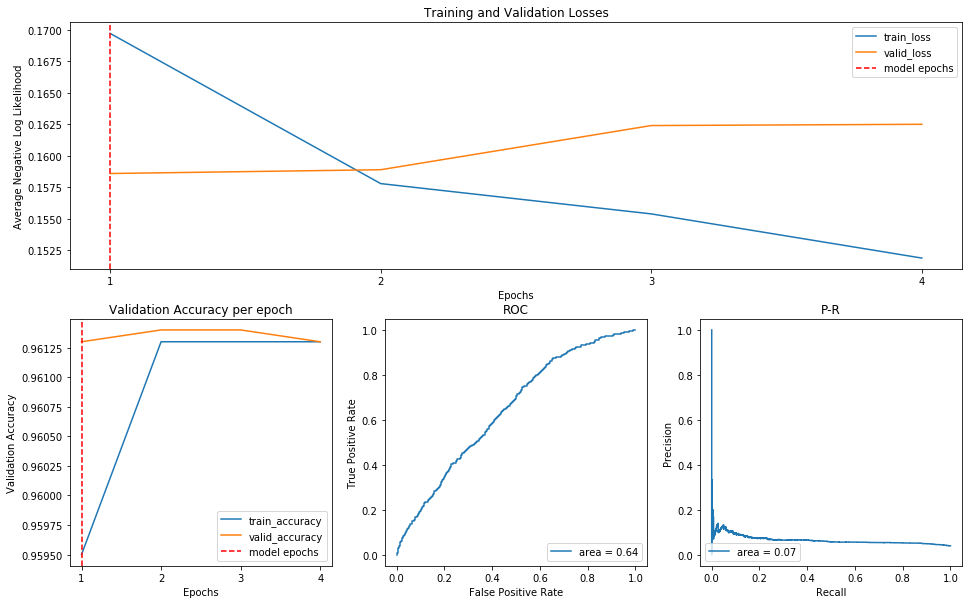

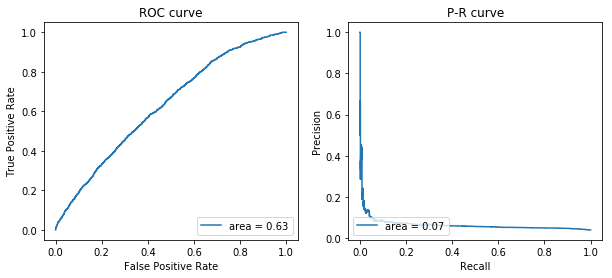

In [16]:
df_name = 'W_WT'

trainset = pd.read_csv(f'../data/cleaned_data/spacers/{df_name}_spacers_cleaned_trainset.csv')
testset = pd.read_csv(f'../data/cleaned_data/spacers/{df_name}_spacers_cleaned_testset.csv')

trainset, validset = train_test_split(trainset, stratify=trainset['label'], 
                                    train_size=7/8, test_size=1/8, shuffle=True)

X_train = trainset['promoter']
y_train = trainset['label']

X_valid = validset['promoter']
y_valid = validset['label']

X_test = testset['promoter']
y_test = testset['label']

batch_size = 100

# Datasets
data = {
    'train':
    Dataset_ConvNeuralNet(X_train, y_train),
    'valid':
    Dataset_ConvNeuralNet(X_valid, y_valid),
    'test':
    Dataset_ConvNeuralNet(X_test, y_test)
}
        
# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True, drop_last=True),
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=True, drop_last=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True, drop_last=True)
}

model = ConvNeuralNet(in_size=64, out_size=2, conv_size=10, output_channels=792, hidden_size=284, dropoutp=0.5)

model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=1e-3)
log = Singlelabel_Logger(print_every=1)

model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    save_file_name=f'delete_me.pt',
    log=log,
    n_epochs=25,
    max_epochs_stop=3,
    plot_metrics=True)

metrics_dict = evaluate(model,
               dataloaders['test'],
               no_of_classes=2,
               plot_metrics=True)